In [1]:
# @title Importando Bibliotecas
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import random


# Data Augmentation

In [2]:
# @title Arrumando Diretórios
destination_path = "./Howard-CloudX-Dataset"
train_dir = destination_path + '/Howard-Cloud-X/train'

class_counts = {}
class_folders = os.listdir(train_dir)

In [37]:
# @title Limpando Arquivos com Extensões Inválidas (Remove não PNG/JPG/JPEG)
import os

# Diretório raiz esperado (train já definido). Deriva test.
root_dataset_dir = os.path.dirname(train_dir)  # .../Howard-Cloud-X
possible_test_dir = os.path.join(root_dataset_dir, 'test')

allowed_ext = {'.png', '.jpg', '.jpeg', '.JPG'}  # extensões válidas (case-insensitive)
scan_dirs = [train_dir]
if os.path.isdir(possible_test_dir):
    scan_dirs.append(possible_test_dir)

arquivos_deletados = []
for base in scan_dirs:
    if not os.path.isdir(base):
        continue
    for class_name in os.listdir(base):
        class_path = os.path.join(base, class_name)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            if not os.path.isfile(fpath):
                continue
            ext = os.path.splitext(fname)[1].lower()  # pega extensão
            if ext not in allowed_ext:  # extensão desconhecida => remove
                try:
                    os.remove(fpath)
                    arquivos_deletados.append(fpath)
                except Exception as e:
                    print(f'Falha ao remover {fpath}: {e}')

print(f'Arquivos removidos (extensões inválidas): {len(arquivos_deletados)}')
if arquivos_deletados:
    # Mostra apenas primeiros para não poluir demais
    for fp in arquivos_deletados[:10]:
        print(' -', fp)
    if len(arquivos_deletados) > 10:
        print(f'... (+{len(arquivos_deletados)-10} adicionais)')


Arquivos removidos (extensões inválidas): 2
 - ./Howard-CloudX-Dataset/Howard-Cloud-X/train/Cirrostratus/87584736-a48c-43ea-b976-93dd6ad66b36.bmp
 - ./Howard-CloudX-Dataset/Howard-Cloud-X/train/Altocumulus/67b7d29c-d320-4d8d-8128-62a124d4138f.102373


In [43]:
# @title Girando Imagens para Aumentação de Dados (Até 200 Imagens por Classe) + Recorte Superior-Central 224x224
target = 250                  # número alvo de imagens por classe após augmentação
crop_size = 224               # tamanho final obrigatório (lado do recorte quadrado)

from PIL import Image


def crop_upper_center(img: Image.Image, size: int = crop_size) -> Image.Image:
    """Recorta quadrado size x size focando centro horizontal e parte superior."""
    w, h = img.size
    if w < size or h < size:               # se imagem pequena, faz upscale proporcional
        scale = max(size / w, size / h)
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))
        img = img.resize((new_w, new_h), Image.BICUBIC)
        w, h = img.size
    cw = size                              # largura do recorte
    ch = size                              # altura do recorte
    left = int(round((w - cw) / 2))        # centraliza horizontalmente
    top_anchor = int(round(h * 0.15))      # desloca recorte para região superior (~15%)
    if top_anchor + ch > h:                # ajusta se ultrapassar limite inferior
        top_anchor = h - ch
    if top_anchor < 0:                     # garantia de não negativo
        top_anchor = 0
    top = top_anchor
    right = left + cw                      # coordenada direita
    bottom = top + ch                      # coordenada inferior
    cropped = img.crop((left, top, right, bottom))  # aplica recorte
    if cropped.size != (size, size):       # normaliza caso algum desvio
        cropped = cropped.resize((size, size), Image.BICUBIC)
    return cropped

# realça luminância alta e suaviza saturação (opcional se ativado)
import numpy as np

def enhance_whites_grays(img):
    arr = np.array(img).astype(np.float32)
    lum = 0.299 * arr[:, :, 0] + 0.587 * arr[:, :, 1] + 0.114 * arr[:, :, 2]  # luminância aproximada
    thresh = np.percentile(lum, 65)            # limiar para destacar áreas mais claras
    mask = lum >= thresh
    arr[mask] = np.clip(arr[mask] * 1.18 + 12.0, 0, 255)  # ganho em brilho/contraste nas regiões claras
    lum3 = lum[:, :, None]
    arr = np.clip(arr * 0.92 + lum3 * 0.08, 0, 255)       # leve desaturação global
    return Image.fromarray(arr.astype(np.uint8))

# Sequência de augmentations:
# 1. Recorte superior-central
# 2. Rotação discreta 0/90/180/270
# 3. Flips horizontais/verticais
# (ColorJitter e realce tons claros permanecem comentados para controle)
augmentations = transforms.Compose([
    transforms.Lambda(lambda img: crop_upper_center(img, crop_size)),  # recorte antes de quaisquer rotações
    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),     # 0° mantém orientação
        transforms.RandomRotation((90, 90)),   # 90°
        transforms.RandomRotation((180, 180)), # 180°
        transforms.RandomRotation((270, 270))  # 270°
    ]),
    transforms.RandomHorizontalFlip(p=0.5),    # espelha horizontal metade das vezes
    transforms.RandomVerticalFlip(p=0.5),      # espelha vertical metade das vezes
    # transforms.ColorJitter(brightness=(1.1, 1.35), contrast=(1.1, 1.5), saturation=(0.6, 0.9), hue=(-0.02, 0.02)),
    # transforms.Lambda(lambda img: enhance_whites_grays(img)),
])

print(f"Recorte superior-central aplicado: {crop_size}x{crop_size}")

for class_name in class_folders:                 # itera cada classe
    class_path = os.path.join(train_dir, class_name)
    current_count = len(os.listdir(class_path))   # conta imagens já existentes
    while current_count < target:                 # gera até atingir target
        img_name = random.choice(os.listdir(class_path))  # escolhe imagem base aleatória
        img_path = os.path.join(class_path, img_name)
        try:
            image = Image.open(img_path).convert('RGB')   # abre e garante RGB
        except Exception:                                # ignora se falhar leitura
            continue
        augmented_image = augmentations(image)            # aplica pipeline
        new_img_name = f'aug_{current_count}_{img_name}'  # nome único derivado
        new_img_path = os.path.join(class_path, new_img_name)
        augmented_image.save(new_img_path)                # salva resultado
        current_count += 1                                # incrementa contador

Recorte superior-central aplicado: 224x224



Número de tamanhos de imagens diferentes: 502
Menor tamanho de imagem (largura, altura): (214, 136)
Maior tamanho de imagem (largura, altura): (6000, 4000)

Imagens Duplicadas
Sem duplicadas


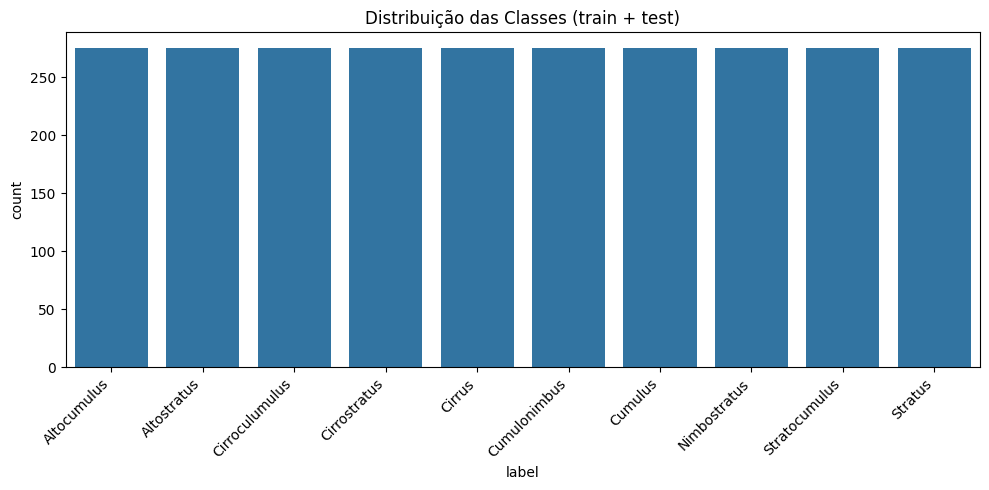

In [3]:
# @title Estatísticas do Dataset

# Define diretório base do dataset de forma robusta
base_dir = os.path.join(destination_path, 'Howard-Cloud-X') if 'destination_path' in globals() else './Howard-CloudX-Dataset/Howard-Cloud-X'

if not os.path.isdir(base_dir):
    raise FileNotFoundError(f"Diretório base não encontrado: {base_dir}")

data_dir = base_dir

# Coleta tamanhos de imagens
image_sizes = set()
for data_type in ['train', 'test']:
    data_type_dir = os.path.join(data_dir, data_type)
    if not os.path.isdir(data_type_dir):
        print(f"Aviso: diretório {data_type_dir} não encontrado.")
        continue
    for class_name in os.listdir(data_type_dir):
        class_dir = os.path.join(data_type_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                try:
                    with Image.open(file_path) as img:
                        image_sizes.add(img.size)
                except Exception:
                    pass

num_unique_sizes = len(image_sizes)
if image_sizes:
    smallest_size = min(image_sizes, key=lambda x: x[0] * x[1])
    largest_size = max(image_sizes, key=lambda x: x[0] * x[1])
    print(f"\nNúmero de tamanhos de imagens diferentes: {num_unique_sizes}")
    print(f"Menor tamanho de imagem (largura, altura): {smallest_size}")
    print(f"Maior tamanho de imagem (largura, altura): {largest_size}")
else:
    print("Nenhuma imagem encontrada para determinar os tamanhos.")

# Construir DataFrame de caminhos e labels
file_paths = []
labels = []
for data_type in ['train', 'test']:
    data_type_dir = os.path.join(data_dir, data_type)
    if not os.path.isdir(data_type_dir):
        continue
    for class_name in os.listdir(data_type_dir):
        class_dir = os.path.join(data_type_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                file_paths.append(file_path)
                labels.append(class_name)

if not file_paths:
    print("Nenhum arquivo coletado para análise.")
else:
    df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    duplicates = df[df.duplicated(subset=['file_path'], keep=False)]
    print("\nImagens Duplicadas")
    if not duplicates.empty:
        display(duplicates.sort_values(by='file_path'))
    else:
        print("Sem duplicadas")

    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribuição das Classes (train + test)')
    plt.tight_layout()
    plt.show()

In [4]:
# @title Treinando EfficientNet (Dropout + Early Stopping + Fine-Tuning Parcial + L1)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report
import os
import numpy as np

# Diretórios (usando base_dir já definido anteriormente)
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    raise FileNotFoundError(f'Diretórios train/test não encontrados em {base_dir}')

# Hiperparâmetros
batch_size = 32
epochs = 50  # early stopping interrompe antes se necessário
learning_rate = 1e-3
num_workers = 2
val_fraction = 0.15   # fração para validação
patience = 6          # early stopping patience
min_delta = 0.0005    # melhoria mínima no val_loss
l1_lambda = 1e-5      # REGULARIZAÇÃO L1
ft_unfreeze_blocks = 2  # FINE-TUNING PARCIAL

# Transforms mínimos
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset base
full_train_dataset = datasets.ImageFolder(train_dir, transform=common_transforms)
num_classes = len(full_train_dataset.classes)
print(f'Classes ({num_classes}): {full_train_dataset.classes}')

# Split validação
val_size = int(len(full_train_dataset) * val_fraction)
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
print(f'Tamanho treino: {train_size} | validação: {val_size}')

test_dataset = datasets.ImageFolder(test_dir, transform=common_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Modelo EfficientNet pré-treinado (sem substituição de bloco custom; arquitetura original)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# --- INÍCIO DROPOUT ---
dropout_rate = 0.2
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(in_features, num_classes)
)
print(f'Dropout aplicado na classifier com p={dropout_rate}')
# --- FIM DROPOUT ---

# --- INÍCIO FINE-TUNING PARCIAL ---
for param in model.features.parameters():
    param.requires_grad = False
# Descongela últimos blocos
total_blocks = len(model.features)
unfreeze_start = max(0, total_blocks - ft_unfreeze_blocks)
for idx, block in enumerate(model.features):
    if idx >= unfreeze_start:
        for p in block.parameters():
            p.requires_grad = True
print(f'Fine-tuning parcial: {ft_unfreeze_blocks} blocos finais descongelados (de {total_blocks})')
# --- FIM FINE-TUNING PARCIAL ---

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Usando dispositivo: {device}')

# Otimizador sem L2 (weight_decay removido)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=learning_rate)
print('Adam configurado SEM weight decay (L2 removido)')
criterion = nn.CrossEntropyLoss()

# Função de treino com L1 manual
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    running_ce_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        ce_loss = criterion(outputs, labels)
        # L1 manual
        l1_penalty = 0.0
        for p in trainable_params:
            l1_penalty += p.abs().sum()
        l1_penalty = l1_lambda * l1_penalty
        total_loss = ce_loss + l1_penalty
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item() * images.size(0)
        running_ce_loss += ce_loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_ce = running_ce_loss / total
    epoch_acc = correct / total
    print(f'[Treino] Epoch {epoch+1} - Loss(total): {epoch_loss:.4f} | CE: {epoch_ce:.4f} | Acc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc, epoch_ce

# Validação
def validate(epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    val_loss = running_loss / total if total > 0 else 0
    val_acc = correct / total if total > 0 else 0
    print(f'[Val]    Epoch {epoch+1} - Loss: {val_loss:.4f} - Acc: {val_acc:.4f}')
    return val_loss, val_acc

# Teste final
def evaluate_test():
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    acc = correct / total if total > 0 else 0
    print(f'[Teste] Acurácia: {acc:.4f}')
    try:
        print('\nClassification Report (Teste):')
        print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
    except Exception as e:
        print(f'Falha ao gerar classification_report: {e}')

# Early Stopping State
best_val_loss = float('inf')
best_epoch = -1
no_improve_count = 0
best_model_state = None
history = []

print('\n===== Iniciando Treinamento =====')
for epoch in range(eepochs := epochs):
    train_loss, train_acc, train_ce = train_one_epoch(epoch)
    val_loss, val_acc = validate(epoch)
    history.append({'epoch': epoch+1, 'train_loss_total': train_loss, 'train_loss_ce': train_ce, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc})

    print(f'[Resumo Epoch] {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch
        no_improve_count = 0
        best_model_state = model.state_dict()
        print(f'>> Melhora validação: val_loss={val_loss:.4f} (epoch {epoch+1})')
    else:
        no_improve_count += 1
        print(f'>> Sem melhora ({no_improve_count}/{patience})')
        if no_improve_count >= patience:
            print(f'EARLY STOPPING ativado na epoch {epoch+1}. Melhor epoch: {best_epoch+1} com val_loss={best_val_loss:.4f}')
            break

    if (epoch + 1) % 10 == 0:
        evaluate_test()

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'Modelo restaurado para melhor epoch {best_epoch+1}')

evaluate_test()

if history:
    avg_train_acc = np.mean([h['train_acc'] for h in history])
    avg_val_acc = np.mean([h['val_acc'] for h in history])
    best_val_acc_entry = max(history, key=lambda h: h['val_acc'])
    print('\n===== Resumo Acurácias =====')
    print(f'Acurácia média (Treino): {avg_train_acc:.4f}')
    print(f'Acurácia média (Validação): {avg_val_acc:.4f}')
    print(f'Melhor Acurácia de Validação: {best_val_acc_entry['val_acc']:.4f} (Epoch {best_val_acc_entry['epoch']})')
    print(f'Total de epochs executadas: {len(history)}')
else:
    print('Histórico vazio - nenhuma epoch registrada.')

model_path = 'efficientnet_b0_clouds_best.pt'
torch.save(model.state_dict(), model_path)
print(f'Modelo salvo em {model_path}')

try:
    import pandas as pd
    pd.DataFrame(history).to_csv('training_history.csv', index=False)
    print('Histórico de treino salvo em training_history.csv')
except Exception:
    pass

Classes (10): ['Altocumulus', 'Altostratus', 'Cirroculumulus', 'Cirrostratus', 'Cirrus', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']
Tamanho treino: 2125 | validação: 374
Dropout aplicado na classifier com p=0.2
Fine-tuning parcial: 2 blocos finais descongelados (de 9)
Usando dispositivo: cuda
Adam configurado SEM weight decay (L2 removido)

===== Iniciando Treinamento =====
[Treino] Epoch 1 - Loss(total): 2.4350 | CE: 1.6844 | Acc: 0.4174
[Val]    Epoch 1 - Loss: 1.3421 - Acc: 0.5267
[Resumo Epoch] 1/50 | Train Acc: 0.4174 | Val Acc: 0.5267 | Train Loss: 2.4350 | Val Loss: 1.3421
>> Melhora validação: val_loss=1.3421 (epoch 1)
[Treino] Epoch 2 - Loss(total): 1.7845 | CE: 1.0364 | Acc: 0.6386
[Val]    Epoch 2 - Loss: 1.2245 - Acc: 0.5829
[Resumo Epoch] 2/50 | Train Acc: 0.6386 | Val Acc: 0.5829 | Train Loss: 1.7845 | Val Loss: 1.2245
>> Melhora validação: val_loss=1.2245 (epoch 2)
[Treino] Epoch 3 - Loss(total): 1.5201 | CE: 0.7740 | Acc: 0.7492
[Val]    Epoc

In [32]:
# @title Analisando a Arquitetura do Modelo Treinado

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Se já modificou classifier no notebook, aplique sua modificação aqui se quiser consistência.
# dropout_rate = 0.5
# in_features = model.classifier[1].in_features
# model.classifier = nn.Sequential(nn.Dropout(p=dropout_rate), nn.Linear(in_features, num_classes))

print("Arquitetura resumida:\n")
print(model)  # imprime hierarquia

# Conta blocos MBConv (classe EfficientNet usa EfficientNet.features como Sequential)
mbconv_blocks = [m for m in model.features if m.__class__.__name__.lower().startswith("mbconv")]
print(f"\nBlocos MBConv: {len(mbconv_blocks)}")

# Conta todas as camadas convolucionais
conv_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
print(f"Total de camadas Conv2d: {len(conv_layers)}")

# Lista primeiras convs para ver formatos
for i, c in enumerate(conv_layers[:5]):
    print(f"Conv {i}: in={c.in_channels}, out={c.out_channels}, k={c.kernel_size}, stride={c.stride}")

# Conta camadas Linear
linear_layers = [m for m in model.modules() if isinstance(m, nn.Linear)]
print(f"Camadas Linear: {len(linear_layers)}")

# Total de parâmetros e parâmetros treináveis (após fine-tuning parcial)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parâmetros totais: {total_params:,}")
print(f"Parâmetros treináveis (atual): {trainable_params:,}")

Arquitetura resumida:

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
         

Principais níveis (estágios) da EfficientNet-B0 (features):


Conv inicial 3x3.

Estágio 1: 1 bloco MBConv1 (k=3).

Estágio 2: 2 blocos MBConv6 (k=3).

Estágio 3: 2 blocos MBConv6 (k=5).

Estágio 4: 3 blocos MBConv6 (k=3).

Estágio 5: 3 blocos MBConv6 (k=5).

Estágio 6: 4 blocos MBConv6 (k=5).

Estágio 7: 1 bloco MBConv6 (k=3).

Cabeça: Conv 1x1 + pooling + classifier (Dropout + Linear)

In [21]:
# @title Reutilizando o Modelo Salvo (Carregamento + Inferência)
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# Caminho dos pesos salvos (apenas state_dict)
WEIGHTS_PATH = 'modelosprontos/efficientnet_b0_clouds_best.pt'  # já gerado anteriormente

# Caso você tenha salvo também um checkpoint completo (dict), poderia usar:
# CKPT_PATH = 'efficientnet_b0_clouds_checkpoint.pt'
# ckpt = torch.load(CKPT_PATH, map_location=device)

# Ajuste conforme usado no treino
NUM_CLASSES = 10  # substitua se diferente
DROPOUT_RATE = 0.2
IMAGE_SIZE = (224, 224)
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo para inferência: {device}')

# Reconstrói a arquitetura exatamente como no treino (features congeladas não importam em inferência)
def build_model(num_classes: int, dropout: float):
    model = models.efficientnet_b0(weights=None)  # weights=None porque vamos carregar state_dict
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, num_classes)
    )
    return model

# Carrega os pesos
model = build_model(NUM_CLASSES, DROPOUT_RATE)
if not os.path.isfile(WEIGHTS_PATH):
    raise FileNotFoundError(f'Arquivo de pesos não encontrado: {WEIGHTS_PATH}')
state = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print('Modelo carregado e pronto para inferência.')

# Transform de inferência (deve casar com o treino)
infer_tf = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Se você tiver a lista de classes original, defina aqui:
# CLASSES = ['Altocumulus', 'Altostratus', 'Cirroculumulus', 'Cirrostratus', 'Cirrus', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']
# Caso não tenha, ajuste manualmente na ordem do ImageFolder usado no treino.
CLASSES = ['Altocumulus', 'Altostratus', 'Cirroculumulus', 'Cirrostratus', 'Cirrus', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']

if len(CLASSES) != NUM_CLASSES:
    print('Aviso: número de classes definido não coincide com NUM_CLASSES.')

@torch.no_grad()
def predict_image(image_path: str):
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f'Imagem não encontrada: {image_path}')
    img = Image.open(image_path).convert('RGB')
    tensor = infer_tf(img).unsqueeze(0).to(device)
    logits = model(tensor)
    probs = torch.softmax(logits, dim=1)[0].cpu()
    idx = int(torch.argmax(probs))
    label = CLASSES[idx] if idx < len(CLASSES) else f'classe_{idx}'
    confidence = float(probs[idx])
    return label, confidence, probs

# Exemplo de uso:
label, conf, probs = predict_image('imagensAleatorisparaTeste/airships-fantasy-art-sky-clouds-wallpaper.png')
print(f'Predição: {label} (confiança={conf:.4f})')
# print('Distribuição de probabilidades por classe:')
# for i, p in enumerate(probs):
#print(f'  {CLASSES[i]:15s}: {p:.4f}')

# Função para prever todas as imagens de uma pasta
@torch.no_grad()
def predict_folder(folder_path: str, limit: int = 10):
    results = []
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Pasta não encontrada: {folder_path}')
    count = 0
    for fname in os.listdir(folder_path):
        if count >= limit:
            break
        fpath = os.path.join(folder_path, fname)
        if not os.path.isfile(fpath):
            continue
        try:
            label, conf, _ = predict_image(fpath)
            results.append((fname, label, conf))
            count += 1
        except Exception as e:
            print(f'Falha em {fname}: {e}')
    return results

# Exemplo pasta:
# preds = predict_folder('./Howard-CloudX-Dataset/Howard-Cloud-X/test/Cirrus', limit=5)
# for fname, label, conf in preds:
#     print(f'{fname}: {label} ({conf:.4f})')

print('Pronto: use predict_image(caminho) ou predict_folder(pasta).')

Dispositivo para inferência: cuda
Modelo carregado e pronto para inferência.
Predição: Nimbostratus (confiança=0.8124)
Pronto: use predict_image(caminho) ou predict_folder(pasta).
Modelo carregado e pronto para inferência.
Predição: Nimbostratus (confiança=0.8124)
Pronto: use predict_image(caminho) ou predict_folder(pasta).
